In [5]:
!pip install opendatasets


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
import os
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import random

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import (
    Dense, Conv2D, MaxPool2D, Dropout, Flatten, 
    BatchNormalization, GlobalAveragePooling2D
)

from keras.applications.densenet import DenseNet121
from keras import backend as K

from sklearn.metrics import confusion_matrix, classification_report


In [2]:
from google.colab import drive
drive.mount('/content/drive')

#Import the libraries
import zipfile
import os

zip_ref = zipfile.ZipFile('/content/drive/MyDrive/new/archive.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/tmp') #Extracts the files into the /tmp folder
zip_ref.close()

Mounted at /content/drive


In [3]:
os.listdir("/tmp/chest_xray")
len(os.listdir("/tmp/chest_xray/train/PNEUMONIA"))

3875

# 📉 Data Visualization

Train set:
PNEUMONIA=3875
NORMAL=1341
Test set:
PNEUMONIA = 390
NORMAL = 234
Validation set:
PNEUMONIA = 8
NORMAL = 8


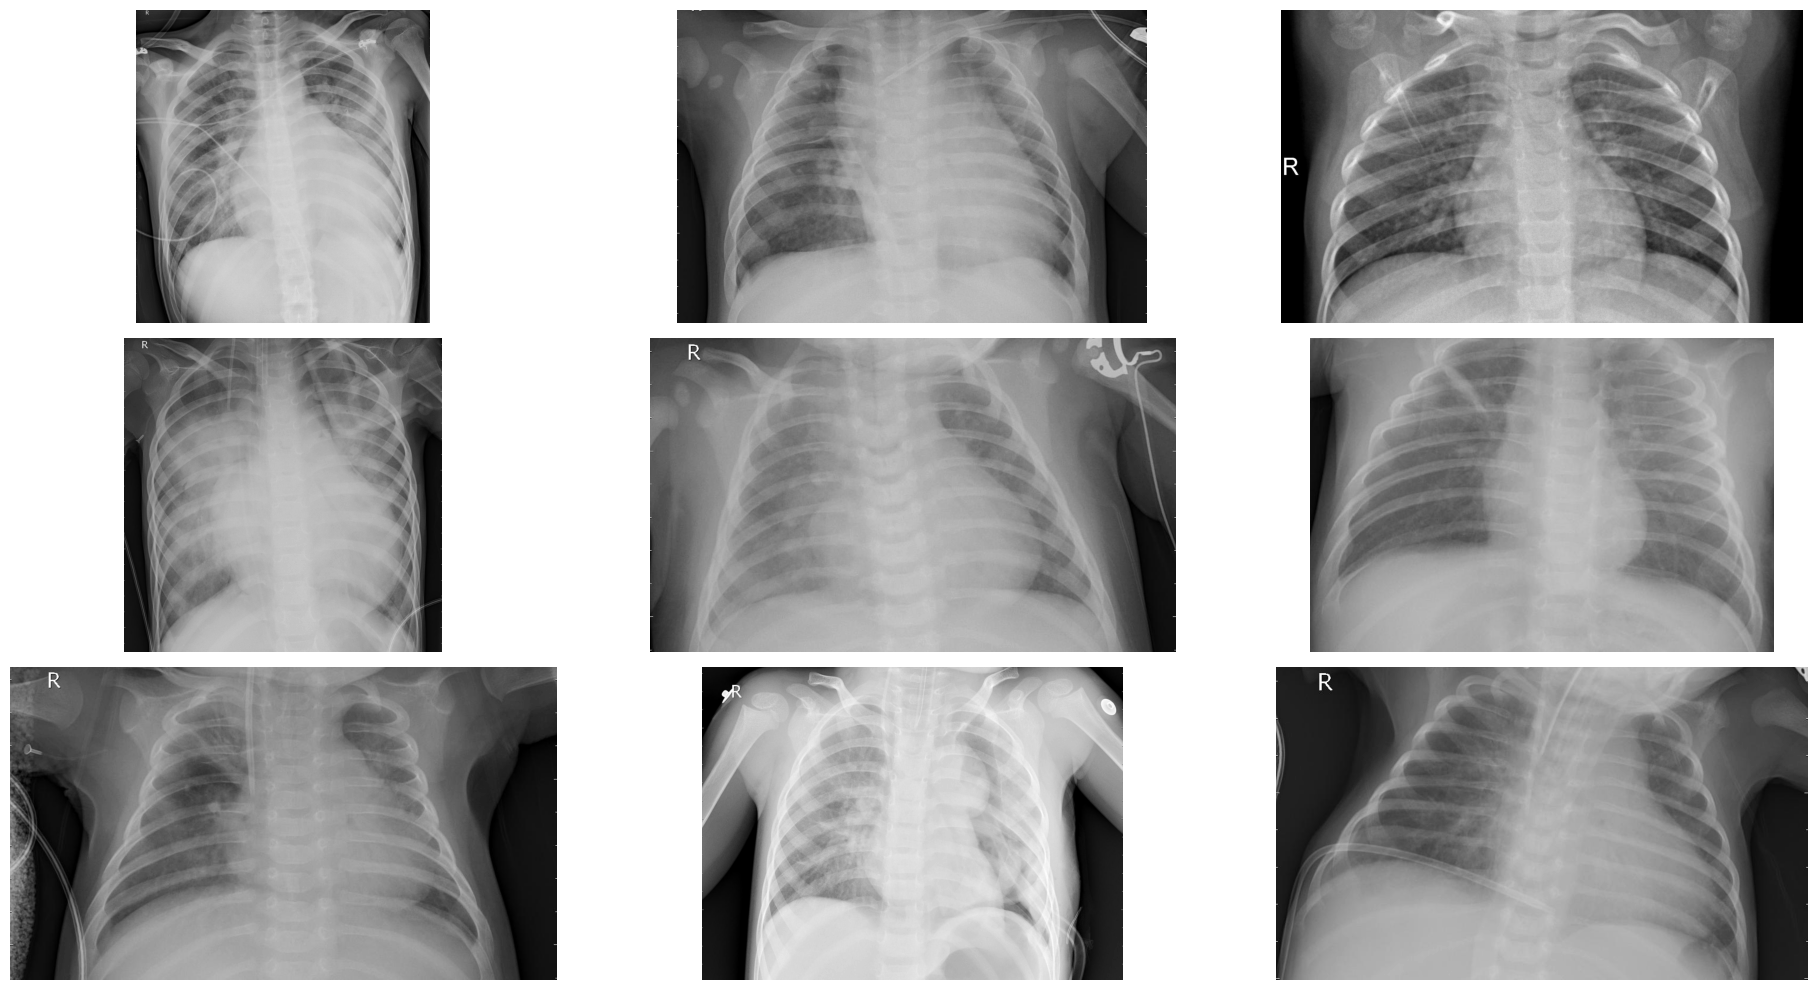

In [5]:
train_dir = "/tmp/chest_xray/train"
test_dir = "/tmp/chest_xray/test"
val_dir = "/tmp/chest_xray/val"

print("Train set:\n========================================")
num_pneumonia = len(os.listdir(os.path.join(train_dir, 'PNEUMONIA')))
num_normal = len(os.listdir(os.path.join(train_dir, 'NORMAL')))
print(f"PNEUMONIA={num_pneumonia}")
print(f"NORMAL={num_normal}")

print("Test set:\n========================================")
print(f"PNEUMONIA = {len(os.listdir(os.path.join(test_dir, 'PNEUMONIA')))}")
print(f"NORMAL = {len(os.listdir(os.path.join(test_dir, 'NORMAL')))}")

print("Validation set:\n========================================")
print(f"PNEUMONIA = {len(os.listdir(os.path.join(val_dir, 'PNEUMONIA')))}")
print(f"NORMAL = {len(os.listdir(os.path.join(val_dir, 'NORMAL')))}")

pneumonia = os.listdir("/tmp/chest_xray/train/PNEUMONIA")
pneumonia_dir = "/tmp/chest_xray/train/PNEUMONIA"

plt.figure(figsize=(20, 10))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(os.path.join(pneumonia_dir, pneumonia[i]))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    
plt.tight_layout()

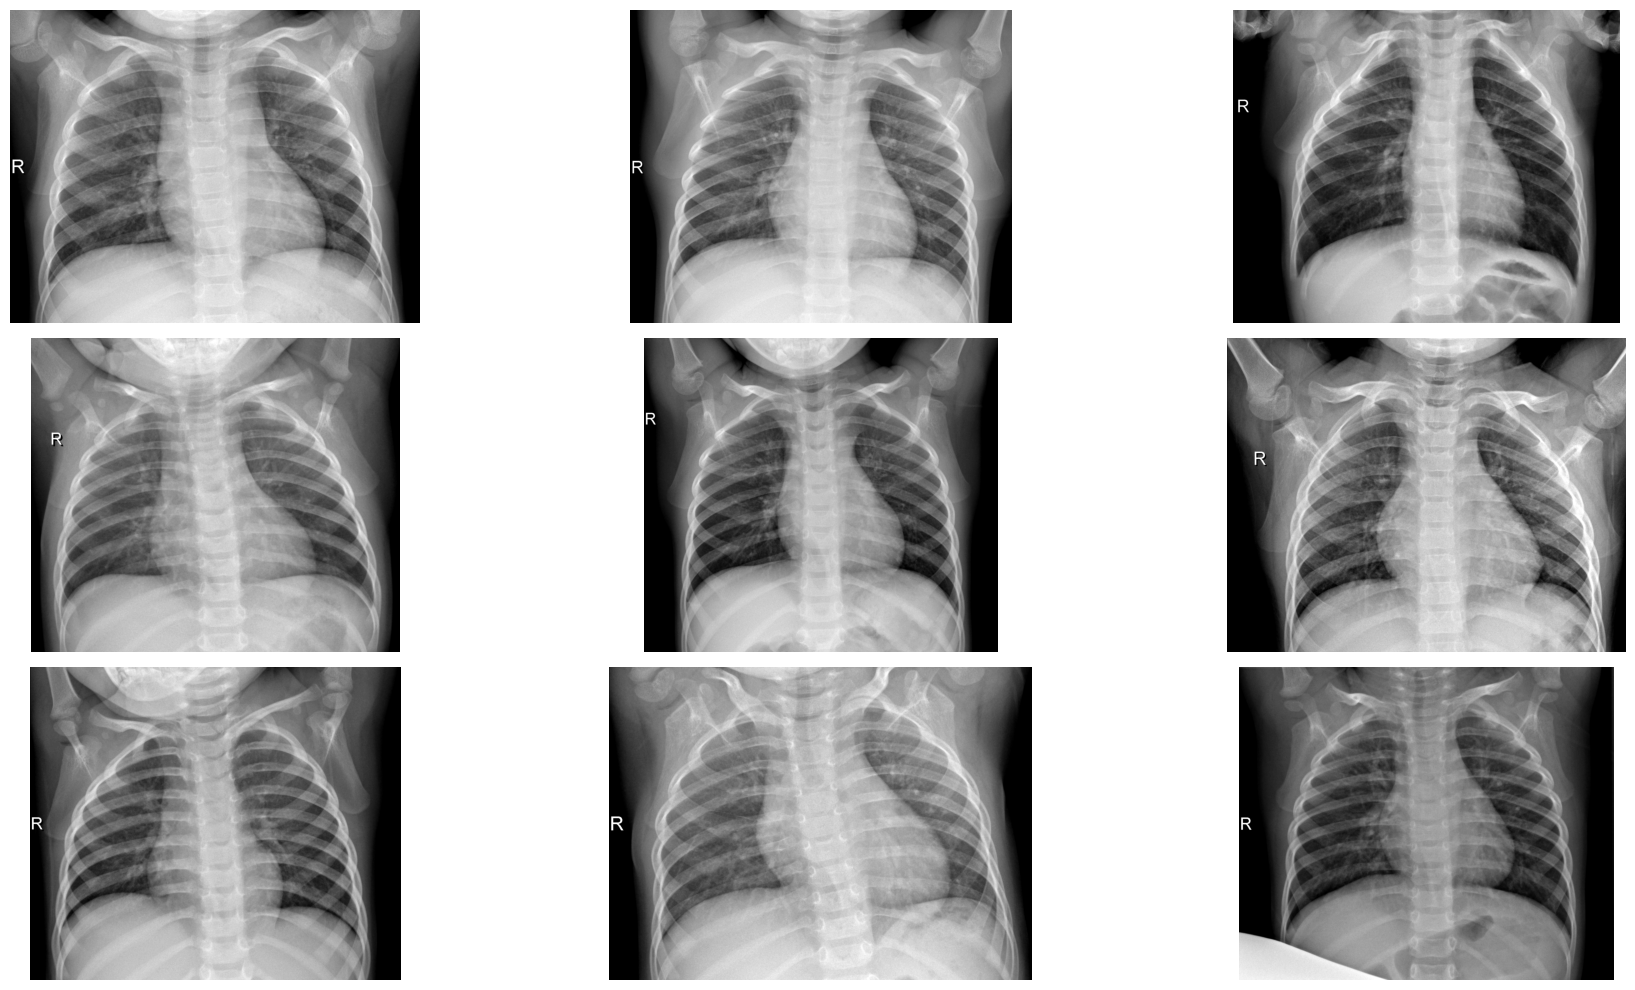

In [6]:
normal = os.listdir("/tmp/chest_xray/train/NORMAL")
normal_dir = "/tmp/chest_xray/train/NORMAL"

plt.figure(figsize=(20, 10))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(os.path.join(normal_dir, normal[i]))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    
plt.tight_layout()

In [7]:
image_generator = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    samplewise_center=True,
    samplewise_std_normalization=True
)

In [8]:
train = image_generator.flow_from_directory(train_dir, 
                                            batch_size=8, 
                                            shuffle=True, 
                                            class_mode='binary',
                                            target_size=(320, 320))

validation = image_generator.flow_from_directory(val_dir, 
                                                batch_size=1, 
                                                shuffle=False, 
                                                class_mode='binary',
                                                target_size=(320, 320))

test = image_generator.flow_from_directory(test_dir, 
                                            batch_size=1, 
                                            shuffle=False, 
                                            class_mode='binary',
                                            target_size=(320, 320))

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [13]:
base_model = DenseNet121(input_shape=(320, 320, 3), include_top=False, weights='imagenet', pooling='avg')

base_model.summary()

29084464/29084464 [==============================] - 2s 0us/step
Model: "densenet121"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 320, 320, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 326, 326, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 160, 160, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                       

In [14]:
layers = base_model.layers
print(f"The model has {len(layers)} layers")

print(f"The input shape {base_model.input}")
print(f"The output shape {base_model.output}")

The model has 428 layers
The input shape KerasTensor(type_spec=TensorSpec(shape=(None, 320, 320, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
The output shape KerasTensor(type_spec=TensorSpec(shape=(None, 1024), dtype=tf.float32, name=None), name='avg_pool/Mean:0', description="created by layer 'avg_pool'")


In [16]:
# model = Sequential()
base_model = DenseNet121(include_top=False, weights='imagenet')
x = base_model.output

x = GlobalAveragePooling2D()(x)

predictions = Dense(1, activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=predictions)
# model.add(base_model)
# model.add(GlobalAveragePooling2D())
# model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

r = model.fit(
    train, 
    epochs=20,
    validation_data=validation,
    class_weight=class_weight,
    steps_per_epoch=100,
    validation_steps=25,
)

Epoch 1/20
100/100 [==============================] - ETA: 0s - loss: 0.1673 - accuracy: 0.7950

100/100 [==============================] - 130s 406ms/step - loss: 0.1673 - accuracy: 0.7950 - val_loss: 22.1681 - val_accuracy: 0.5000
Epoch 2/20
100/100 [==============================] - 37s 368ms/step - loss: 0.1134 - accuracy: 0.8687
Epoch 3/20
100/100 [==============================] - 37s 364ms/step - loss: 0.0945 - accuracy: 0.8938
Epoch 4/20
100/100 [==============================] - 35s 349ms/step - loss: 0.0881 - accuracy: 0.9038
Epoch 5/20
100/100 [==============================] - 44s 439ms/step - loss: 0.0967 - accuracy: 0.9025
Epoch 6/20
100/100 [==============================] - 45s 452ms/step - loss: 0.0914 - accuracy: 0.8900
Epoch 7/20
100/100 [==============================] - 36s 364ms/step - loss: 0.0899 - accuracy: 0.9000
Epoch 8/20
100/100 [==============================] - 38s 378ms/step - loss: 0.0745 - accuracy: 0.9212
Epoch 9/20
100/100 [==============================] - 36s 358ms/step - loss: 0.0773 - accuracy: 0.9250
Epoch 10/20
100/100 [===================

In [17]:
model.save('pneumonia_detection_model_densenet.h5')

Text(0.5, 1.0, 'Accuracy Evolution')

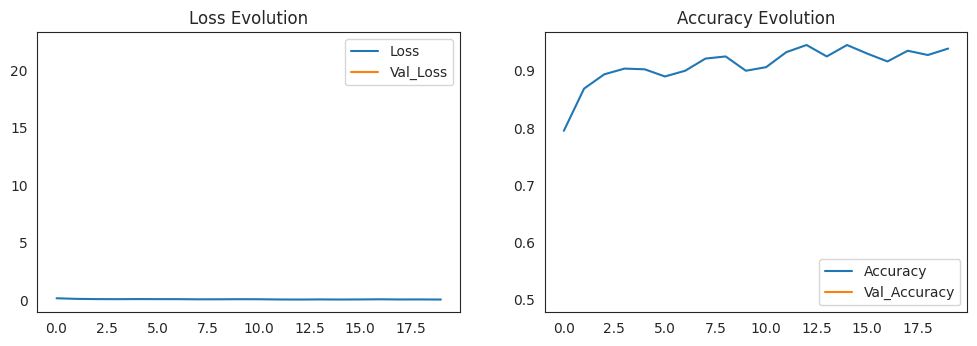

In [18]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(r.history['loss'], label='Loss')
plt.plot(r.history['val_loss'], label='Val_Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(2, 2, 2)
plt.plot(r.history['accuracy'], label='Accuracy')
plt.plot(r.history['val_accuracy'], label='Val_Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

In [19]:
evaluation = model.evaluate(test)
print(f"Test Accuracy: {evaluation[1] * 100:.2f}%")

evaluation = model.evaluate(train)
print(f"Train Accuracy: {evaluation[1] * 100:.2f}%")

624/624 [==============================] - 35s 57ms/step - loss: 0.8087 - accuracy: 0.8077
Test Accuracy: 80.77%
652/652 [==============================] - 198s 303ms/step - loss: 0.1182 - accuracy: 0.9580
Train Accuracy: 95.80%


# Evaluation

In [23]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.models import Model, load_model
img_size = (299, 299)
batch_size = 32

In [24]:
# Load the trained model
model = load_model('/content/pneumonia_detection_model_densenet.h5')

# Define path to test images
test_path = '/tmp/chest_xray/test'

# Create a data generator for testing
test_datagen = image.ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = test_datagen.flow_from_directory(test_path, target_size=img_size, batch_size=batch_size, class_mode='binary', shuffle=False)

# Make predictions on the test images
predictions = model.predict(test_generator)

# Convert predictions to binary labels (0 or 1)
predicted_labels = np.round(predictions)

# Get true labels for the test images
true_labels = test_generator.classes

# Calculate accuracy and other metrics
accuracy = np.mean(predicted_labels == true_labels)
precision = np.sum((predicted_labels == 1) & (true_labels == 1)) / np.sum(predicted_labels == 1)
recall = np.sum((predicted_labels == 1) & (true_labels == 1)) / np.sum(true_labels == 1)
f1_score = 2 * precision * recall / (precision + recall)

# Print metrics
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1_score)


Found 624 images belonging to 2 classes.
20/20 [==============================] - 16s 496ms/step
Accuracy: 0.6237980769230769
Precision: 390.0
Recall: 621.0
F1 Score: 479.10979228486644
